In [1]:
import numpy as np
import xarray as xr 
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

import grid2d_moments_utils as gmu

%matplotlib inline

## We'll use the months of Jan-Mar 2009 as a test for calculating moments of the stratospheric polar vortex

We use data from the NCEP-NCAR reanalysis for this example. Note: For stratospheric applications, NCEP-NCAR reanalysis data is generally not recommended since it has a relatively poor representation of the stratosphere compared to other modern reanalysis datasets. However, for the purposes of this example and using the code, it's good enough. Plus it's easy to access and has a low memory footprint.

In [2]:
# Define the link to the data
rean_link = 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Dailies/pressure/hgt.2009.nc'

In [3]:
# Read the geopotential height data
z = xr.open_dataarray(rean_link)
z

<xarray.DataArray 'hgt' (time: 365, level: 17, lat: 73, lon: 144)>
[65226960 values with dtype=float32]
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * time     (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
Attributes: (12/13)
    long_name:     mean Daily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    ...            ...
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Individual Obs
    actual_range:  [ -516. 32271.]
    valid_range:   [ -700. 35000.]
    _ChunkSizes:   [  1   1  73 144]

In [4]:
# For this example, we are only interested in the 10 hPa level (middle stratosphere)
# and the time period from Jan thru March
z = z.sel(level=10, time=slice('2009-01-01','2009-03-31')).load()

We'll make a test map of the geopotential height data during the 24 January 2009 SSW. 

Let's define the vortex edge at 10 hPa to be Z = 30200m (note: this is arbitrary, but reasonable)

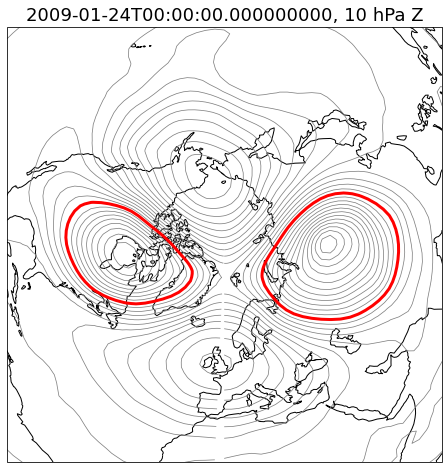

In [5]:
# We will highlight this contour on the map, and use it for the moment diagnostics
vortex_edge = 30200

# The SSW occurred on 24 January 2009
date2ana = '2009-01-24'

# Define our projections that we will use for defining cartesian coordinates from the input lat/lon data
data_proj = ccrs.Geodetic() # input data is lat/lon
cart_proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90, central_longitude=0) # regrid to equal area 

# Convenience function for making a quick map
def plot_vortex(z, vortex_edge, fig_num, plot_crs):
    data_crs = ccrs.PlateCarree()

    fig = plt.figure(fig_num)
    ax = plt.axes(projection = plot_crs)
    ax.set_extent([-180, 180, 20, 90], data_crs)
    ax.coastlines()

    plt.contour(z.lon, z.lat, z, 
                levels=np.arange(25000,35001,100),  
                colors="grey",linewidths=0.75, transform=data_crs)
    plt.contour(z.lon, z.lat, z, 
                levels=[vortex_edge], 
                colors="red", linewidths=3, transform=data_crs)

    plt.title(f"{z.time.values}, 10 hPa Z", fontsize=18)
    fig.set_size_inches(8,8)
    
    return fig,ax


fig,ax = plot_vortex(z.sel(time=date2ana), vortex_edge, 0, cart_proj)

## Regrid from spherical to cartesian coordinates using cartopy and the grid2d_moments_utils functions

In [6]:
# Define the number of points in each direction we'll use for the regular cartesian grid we'll interpolate to
nx = ny = 100

# At this point we limit our data to the northern hemisphere only since we 
# are using a north polar projection (we do not want the SH points to be considered 
# as part of the input grid)
z_nh = z.sel(lat=slice(90,0), time=date2ana)

# We are going to find what the input lat/lon coordinates are in the 
# cartesian coordinate system "in_ccoords" (input cartesian coordinates)
lons,lats = np.meshgrid(z_nh.lon.values, z_nh.lat.values)
in_ccoords = cart_proj.transform_points(data_proj, lons.ravel(), lats.ravel())
in_ccoords = in_ccoords[...,0:2]

# Now we define the regular cartesian grid that we want to regrid to
# "out_ccoords" (output cartesian coordinates)
out_ccoords = gmu.gen_regular_grid_from_irreg(in_ccoords, nx, ny)

# Calculate the interpolation parameters
vtx,wts = gmu.get_interp_params(in_ccoords, out_ccoords)

print(f"in_ccoords shape: {in_ccoords.shape}")
print(f"out_ccoords shape: {out_ccoords.shape}")

in_ccoords shape: (5328, 2)
out_ccoords shape: (10000, 2)


At this point, we have everything we need to regrid from the spherical lat/lon data to the cartesian grid. The advantage of what we've done is that we've saved the interpolation parameters, which means that as long as we continue to use fields on the same lat/lon grid, we can easily and quickly regrid them (the calculation of the interpolation params is what takes the longest)

In [7]:
# the apply_interp function expects the data to be in the same 
# shape as the input cartesian coordinates, which would be 
# (num_lats*num_lons) in size
nlats = z_nh.lat.size
nlons = z_nh.lon.size
new_shape = (nlats*nlons,)

# now we can regrid
z_nh_regrid= gmu.apply_interp(z_nh.values.reshape(new_shape), vtx, wts)

For confirmation, let's plot the data in the cartesian coordinates. We'll also highlight the areas where there are NaNs.

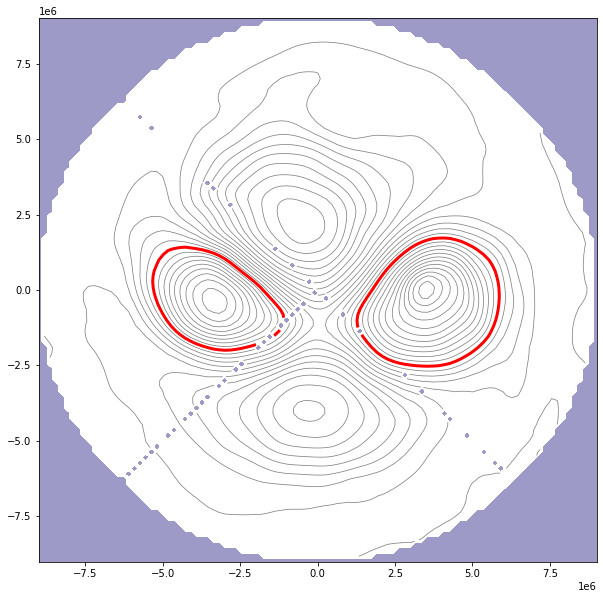

In [8]:
xout = out_ccoords[:,0].reshape((nx,ny))
yout = out_ccoords[:,1].reshape((nx,ny))
plt.contour(xout, yout, z_nh_regrid.reshape((nx,ny)), levels=np.arange(25000,35001,100),  
            colors="grey",linewidths=0.75)
plt.contour(xout, yout, z_nh_regrid.reshape((nx,ny)), levels=[vortex_edge],  
            colors="red",linewidths=3)
plt.contourf(xout,yout,np.isnan(z_nh_regrid.reshape((nx,ny))), levels=[0.66,1], cmap='Purples')
plt.gcf().set_size_inches(10,10)

First let's discuss the ring of NaNs in purple surrounding the region of good data in the middle -- this ring exists because the "output grid" we have interpolated to goes out of bounds. We have essentially asked for a square domain on top of a circular map projection. This is not really a problem though, because we can just treat these points as if they don't exist. 

Now let's discuss the diagonal lines of NaNs in the spots where there should be good data. Why are these there? Good question! I'm asking you because I'm not sure myself! :) These appear to fall along constant lines of longitude around -135, -45, 45, and 135 degrees, so I assume it may have something to do with the trigonometric transformations from Spherical->Cartesian, and something going on with the Delaunay triangulation. This issue can effectively be fixed by adding some numerically-insignificant "jitter" to the *input* coordinates transformed to Cartesian, as shown below. 

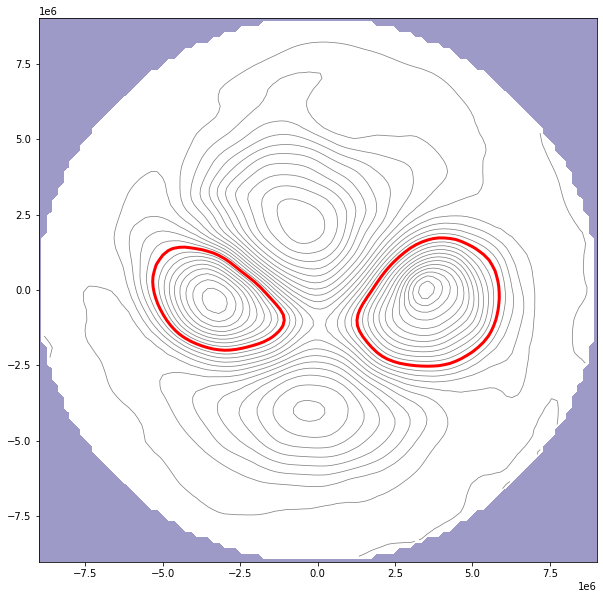

In [9]:
### Fix the issue with missing data in regions that should be defined

# Generate some numerically-insignificant jitter
np.random.seed(0) # for reproducibility, set the seed
jitter = np.random.uniform(low=-1, high=1, size=in_ccoords.shape)*1.0e-5

# Now we define the regular cartesian grid that we will regrid to with 
# the jitter added to define "out_ccoords" (output cartesian coordinates)
out_ccoords = gmu.gen_regular_grid_from_irreg(in_ccoords+jitter, nx, ny)
vtx,wts = gmu.get_interp_params(in_ccoords+jitter, out_ccoords)

# now we can try regridding again
z_nh_regrid= gmu.apply_interp(z_nh.values.reshape(new_shape), vtx, wts)

# and now plot
xout = out_ccoords[:,0].reshape((nx,ny))
yout = out_ccoords[:,1].reshape((nx,ny))
plt.contour(xout, yout, z_nh_regrid.reshape((nx,ny)), levels=np.arange(25000,35001,100),  
            colors="grey",linewidths=0.75)
plt.contour(xout, yout, z_nh_regrid.reshape((nx,ny)), levels=[vortex_edge],  
            colors="red",linewidths=3)
plt.contourf(xout,yout,np.isnan(z_nh_regrid.reshape((nx,ny))), levels=[0.66,1], cmap='Purples')
plt.gcf().set_size_inches(10,10)

## Calculate the moments
At this point we can now calculate the moments. I'll demonstrate how to get the values for the "weighted" and "geometric" calculations, and compare the values. Later we'll plot equivalent ellipses on the map of the geopotential heights.

In [10]:
# Calculate the moments with data weighting. We specify the vortex region as
# being heights *less than* (lt) vortex edge contour
moments_wtd = gmu.calc_2d_moments(z_nh_regrid, out_ccoords[:,0], out_ccoords[:,1], 
                                  edge = vortex_edge, isolation = "lt", mom_type="wtd")

# Calculate the moments with no weighting. We specify the vortex region as 
# being heights *less than* (lt) the vortex edge contour
moments_geom = gmu.calc_2d_moments(z_nh_regrid, out_ccoords[:,0], out_ccoords[:,1],
                                   edge = vortex_edge, isolation = "lt", mom_type="geom")

# Transform the cartesian points to lat/lon
clon_wtd,   clat_wtd = data_proj.transform_points(cart_proj,  moments_wtd["xcent"],  moments_wtd["ycent"])[0,0:2]
clon_geom, clat_geom = data_proj.transform_points(cart_proj, moments_geom["xcent"], moments_geom["ycent"])[0,0:2]


# Print out the results
print(f"Weighted Centroid  (x,y): {moments_wtd['xcent']}, {moments_wtd['ycent']}")
print(f"Weighted Centroid  (lat, lon): {clat_wtd}, {clon_wtd}")
print(f"Geometric Centroid (x,y): {moments_geom['xcent']}, {moments_geom['ycent']}")
print(f"Geometric Centroid (lat, lon): {clat_geom}, {clon_geom}")

Weighted Centroid  (x,y): 1072772.4323541245, -385889.6066306753
Weighted Centroid  (lat, lon): 79.77831043765742, 70.21570982935403
Geometric Centroid (x,y): 799106.9850994796, -445545.69972546847
Geometric Centroid (lat, lon): 81.80111302792514, 60.85795091247194


Notice how the centroid calculated using data weighting has a greater x-value and smaller latitude than the geometric centroid? This is because the size and strength of the offspring vortex on the right side (over Siberia) is larger and has lower geopotential heights, so it has a greater weighting on the centroid than the smaller region (over Canada), which shifts it off the pole. The geometric centroid is closer to x = 0 (or more near the pole) since the larger region doesn't have as big of an impact without the data weighting.

## Define the equivalent ellipse
For studies of the polar vortex, it's common to want to define an "equivalent ellipse" using the centroid coordinates, aspect ratio, and angle to simplify the vortex geometry (e.g., for purposes of classifying sudden stratospheric warmings). However, to do this, we need the area of the vortex region *__in the cartesian coordinates__*. Since we have interpolated our data to a uniform cartesian grid, the area is equal to the number of points multiplied by the width and height of the gridboxes. 

We will find the coordinates of the ellipse's circumference in the cartesian coordinates, and transrom them to spherical

In [11]:
# Get the size of our gridpoints for scaling the area
dx = xout[0,1] - xout[0,0] # x points vary along axis=1
dy = yout[1,0] - yout[0,0] # y points vary along axis=0

# Get the ellipse cartesian coordinates "ell_ccoords"
ell_ccoords = gmu.equivalent_ellipse(moments_geom['npoints']*dx*dy, moments_geom["angle"], moments_geom["asrat"],
                                     moments_geom["xcent"], moments_geom["ycent"], npoints=250)

# transform the cartesian coordinates to spherical "ell_scoords"
ell_scoords = data_proj.transform_points(cart_proj,  ell_ccoords[:,0],  ell_ccoords[:,1])[:,0:2]

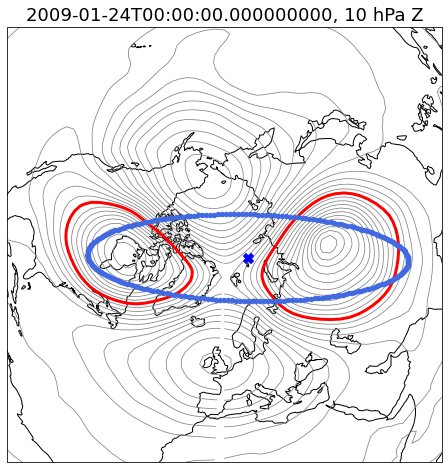

In [12]:
# Make the map
fig,ax = plot_vortex(z.sel(time=date2ana), vortex_edge, 0, cart_proj)

# Plot the centroid location with a darker blue x, and the ellipse in lighter blue
ax.scatter(clon_geom, clat_geom, color='blue', marker='X', transform=ccrs.PlateCarree(), s=100, zorder=10)
ax.scatter(ell_scoords[:,0], ell_scoords[:,1], color='RoyalBlue', transform=ccrs.PlateCarree(), s=20, zorder=10)

The above example may look a bit weird because the vortex is split into two, and so the ellipse has a high aspect ratio. I recommend trying some other dates (e.g., Jan 1) to see just how well the equivalent ellipse can match the vortex region! While you're at it, try changing the coordinate system that you interpolate to (e.g., try "Orthographic") to confirm the code still works. See the "date2ana" and "cart_proj" variables.

## A quick aside
In this example, we have cleverly transformed to an equal-area coordinate system that spans from equator to pole, so it is possible to get a good estimate of the vortex area in the spherical coordinates. We can do this by finding the *relative* area of the vortex region in cartesian coordinates, which will also give us the relative area of the region in the Northern Hemisphere (i.e., the fraction of the hemisphere). This is equal to the number of points inside the vortex region, divided by the total number of points inside the Northern Hemisphere circle. Keep in mind this only works for equal-area coordinates.

In [13]:
# The number of points inside the NH circle is everywhere that's non-NaN
total_points = np.sum(~np.isnan(z_nh_regrid)) 
area_frac = moments_geom['npoints'] / total_points
print(f"Fractional area: {area_frac}")

Fractional area: 0.09741784037558686


## Putting it all together
In general, one would probably want to calculate the moment diagnostics for multiple vertical levels and/or timesteps. Below I show an example of how you can simply use for-loops to accomplish this. I will reuse some code from cells above to make this a mostly self-contained example.

In [14]:
vortex_edge = 30200

data_proj = ccrs.Geodetic() # input data is lat/lon
cart_proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90, central_longitude=0) # regrid to equal area 

# Define the number of points in each direction we'll use for the regular cartesian grid we'll interpolate to
nx = ny = 100

# Limit our data to the northern hemisphere only
z_nh = z.sel(lat=slice(90,0))
nlats = z_nh.lat.size
nlons = z_nh.lon.size
new_shape = (nlats*nlons,)

# Define the cartesian coordinates of the input lats/lons
lons,lats = np.meshgrid(z_nh.lon.values, z_nh.lat.values)
in_ccoords = cart_proj.transform_points(data_proj, lons.ravel(), lats.ravel())
in_ccoords = in_ccoords[...,0:2]

# Generate some numerically-insignificant jitter
np.random.seed(0) # for reproducibility, set the seed
jitter = np.random.uniform(low=-1, high=1, size=in_ccoords.shape)*1.0e-5

# Define the regular cartesian grid we will interpolate to
# with added jitter to help the Delaunay triangulation
out_ccoords = gmu.gen_regular_grid_from_irreg(in_ccoords+jitter, nx, ny)
vtx,wts = gmu.get_interp_params(in_ccoords+jitter, out_ccoords) # <-- Important that this line be outside the for-loop! 

clat = []
asrat = []

for i,time in enumerate(z_nh.time):
    z_nh_regrid = gmu.apply_interp(z_nh.sel(time=time).values.reshape(new_shape), vtx, wts) # <-- Do regridding inside the for-loop!
    
    moments = gmu.calc_2d_moments(z_nh_regrid, out_ccoords[:,0], out_ccoords[:,1],
                                  edge = vortex_edge, isolation = "lt", mom_type="geom")
    
    centroid_coords = data_proj.transform_points(cart_proj, np.array(moments["xcent"]), np.array(moments["ycent"]))
    clat.append(centroid_coords[0,1])
    asrat.append(moments['asrat'])    

/home/zdl/grid2d-moments-utils/grid2d_moments_utils.py:316: RuntimeWarning: invalid value encountered in double_scalars
  asrat = np.sqrt(np.abs((j20_plus_j02 + sqrt_j2_terms) \
/home/zdl/grid2d-moments-utils/grid2d_moments_utils.py:320: RuntimeWarning: invalid value encountered in double_scalars
  ek1 = m00*((j40 + 2*j22 + j04)/((j20+j02)**2))


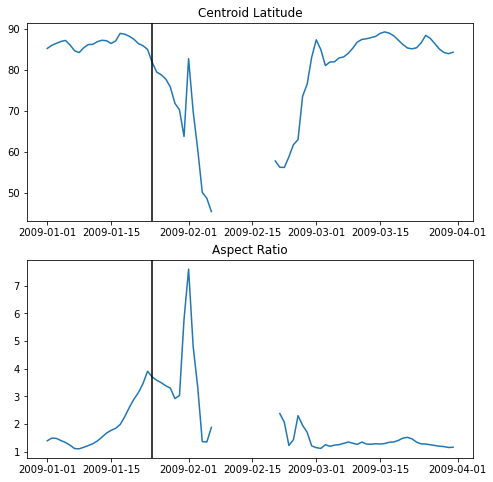

In [15]:
fig = plt.figure()

ax = fig.add_subplot(2,1,1)
plt.plot(z_nh.time.values, clat)
plt.title("Centroid Latitude")
plt.axvline(np.datetime64('2009-01-24'), color='black')

ax = fig.add_subplot(2,1,2)
plt.plot(z_nh.time.values, asrat)
plt.title("Aspect Ratio")
plt.axvline(np.datetime64('2009-01-24'), color='black')

fig.set_size_inches(8,8)

The above example only finds the data as a function of time, but a similar process can be used to do time+vertical level with a double for-loop (one for vertical level, and one for time). Since the code in grid2d_moments_utils generally assumes it will be working with 2D slices of data, the above process can not really be vectorized to work across dimensions without there being iteration somewhere (if I'm wrong, please submit a pull request :)). This is an "embarrassingly parallel" problem, though, so it is possible to speed things up with parallel processing using a library such as joblib if using the for-loops alone is too slow (this is left as an exercise to the reader). The important thing that makes this all relatively fast is that the interpolation weights are calculated once, and then they're reused to do regridding for every new timestep/level inside the for-loop(s). 